# Predicciones machine learning

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from scipy.stats import f_oneway, kruskal #importamos estas librerías para su uso en los test de kruskal wallis y anova de una vía.

from sklearn.model_selection import train_test_split #Para separar en conjunto de entrenamiento y de prueba.
from sklearn.linear_model import LinearRegression #importamos la función para la creación de modelos de regresión lineal de sklearn.
from sklearn.metrics import mean_squared_error, r2_score #importamos las funciones para el cálculo de métricas de bondad de ajuste R^2 y MSE.
import statsmodels.api as sm #Importamos librería statsmodels que entrega los modelos de regresión. Servirá para utilizar modelos de regresión lineal.
from statsmodels.miscmodels.ordinal_model import OrderedModel #para utilizar el modelo multinomial ordinal.
from imblearn.over_sampling import SMOTE #para realizar remuestreo con SMOTE y balanceo de clases.

#Importamos métricas para medir la eficacia del modelo de clasificación multinomial ordinal.
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, classification_report, cohen_kappa_score, f1_score
from sklearn.metrics import confusion_matrix

import joblib

fecha_scraping = datetime.now().strftime("%Y-%m-%d").replace("-","_")

#Función para estandarizar variables numéricas.
def estandarizar(df):
    df_scaled = df.copy()
    num_cols = df.select_dtypes(include="number").columns
    
    df_scaled[num_cols] = (df[num_cols] - df[num_cols].mean()) / df[num_cols].std()
    
    return df_scaled


In [ ]:
#Importamos los datos
df = pd.read_csv(f"../data/processed/ofertas_2025_08_24.csv", sep=";", decimal=",", encoding="utf-8")
df = df.drop(columns=["fecha_extraccion"])

In [16]:
#Reasignaremos valores de la variable categórica de "encuadernación" con menor frecuencia que 10, ya que serían muy pocos para considerar en un modelo.
frecuencias = df["encuadernacion"].value_counts()
df["encuadernacion"] = np.where(df["encuadernacion"].map(frecuencias) >= 10, df["encuadernacion"], "otro")

#Reasignaremos valores de la variable categórica de "editorial" con menor frecuencia que 10, ya que serían muy pocos para considerar en un modelo.
frecuencias = df["editorial"].value_counts()
df["editorial"] = np.where(df["editorial"].map(frecuencias) >= 10, df["editorial"], "otro")

#Reasignaremos valores de la variable categórica de "encuadernación" con menor frecuencia que 10, ya que serían muy pocos para considerar en un modelo.
frecuencias = df["macrocategoria"].value_counts()
df["macrocategoria"] = np.where(df["macrocategoria"].map(frecuencias) >= 10, df["macrocategoria"], "otro")

#Creamos una variable categórica que indica los rangos de descuento. Será utilizada como variable objetivo para uno de los modelos.
bins = [-float("inf"), 0.19, 0.24, 0.29, float("inf")]
labels = ["<0.2", "0.20-0.24", "0.25-0.29", "0.3 o más"]
df["rango_descuento"] = pd.cut(df["porcentaje_descuento"], bins=bins, labels=labels)

In [17]:
df["rango_descuento"].value_counts()

rango_descuento
0.25-0.29    1587
0.3 o más     909
<0.2          163
0.20-0.24      60
Name: count, dtype: int64

### Comparación variables precio_original según variables categóricas

ANOVA -> F = 175.83909646180442 p-valor = 4.788084679971915e-215
Kruskal-Wallis -> H = 579.6886326920029 p-valor = 5.751719285333708e-121


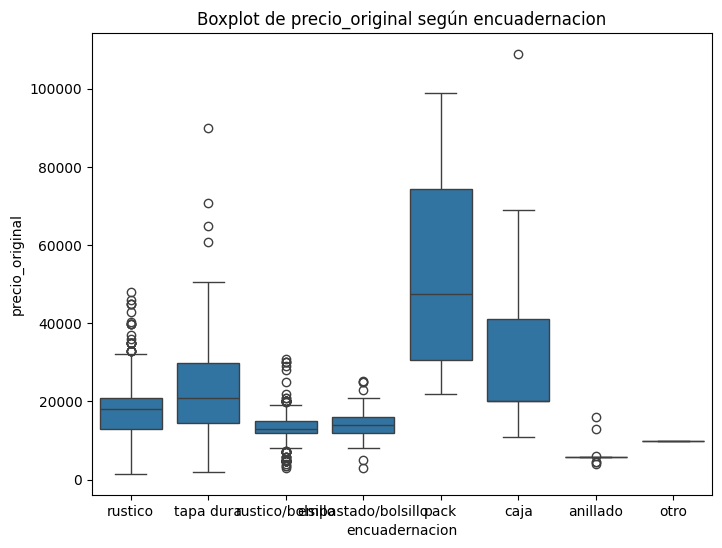

8

In [18]:
#Realizamos test anova y kruskal wallis para la variable encuadernacion
grupos = [g["precio_original"].values for _, g in df.groupby("encuadernacion")]
f_stat, p_anova = f_oneway(*grupos)
print("ANOVA -> F =", f_stat, "p-valor =", p_anova)
h_stat, p_kw = kruskal(*grupos)
print("Kruskal-Wallis -> H =", h_stat, "p-valor =", p_kw)
# Boxplot
plt.figure(figsize=(8,6))
sns.boxplot(x="encuadernacion", y="precio_original", data=df)
plt.title("Boxplot de precio_original según encuadernacion")
plt.show()
len(df["encuadernacion"].value_counts())

ANOVA -> F = 23.829743107386758 p-valor = 4.8307066756349196e-167
Kruskal-Wallis -> H = 1225.2198972098406 p-valor = 8.82010040569009e-226


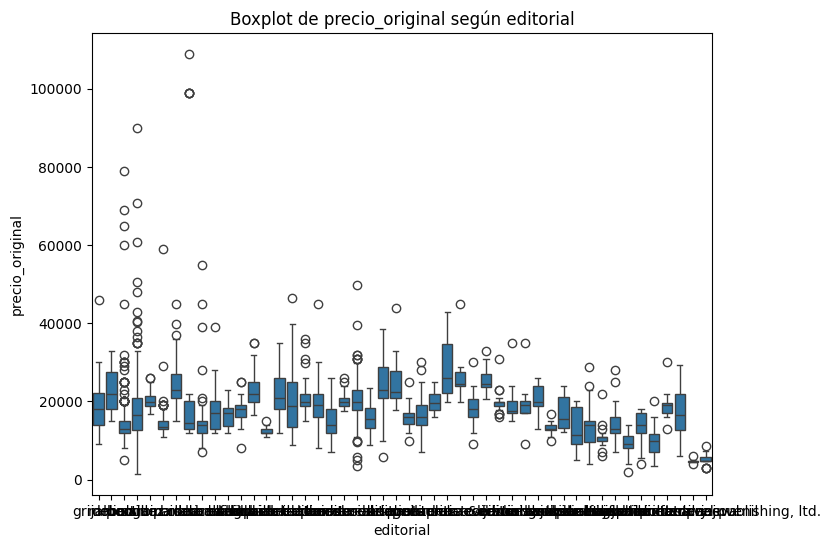

48

In [19]:
#Realizamos test anova y kruskal wallis para la variable editorial
grupos = [g["precio_original"].values for _, g in df.groupby("editorial")]
f_stat, p_anova = f_oneway(*grupos)
print("ANOVA -> F =", f_stat, "p-valor =", p_anova)
h_stat, p_kw = kruskal(*grupos)
print("Kruskal-Wallis -> H =", h_stat, "p-valor =", p_kw)
# Boxplot
plt.figure(figsize=(8,6))
sns.boxplot(x="editorial", y="precio_original", data=df)
plt.title("Boxplot de precio_original según editorial")
plt.show()
len(df["editorial"].value_counts())

ANOVA -> F = 14.597495363019517 p-valor = 1.7359957513454248e-96
Kruskal-Wallis -> H = 670.6548872575087 p-valor = 2.081245679568421e-112


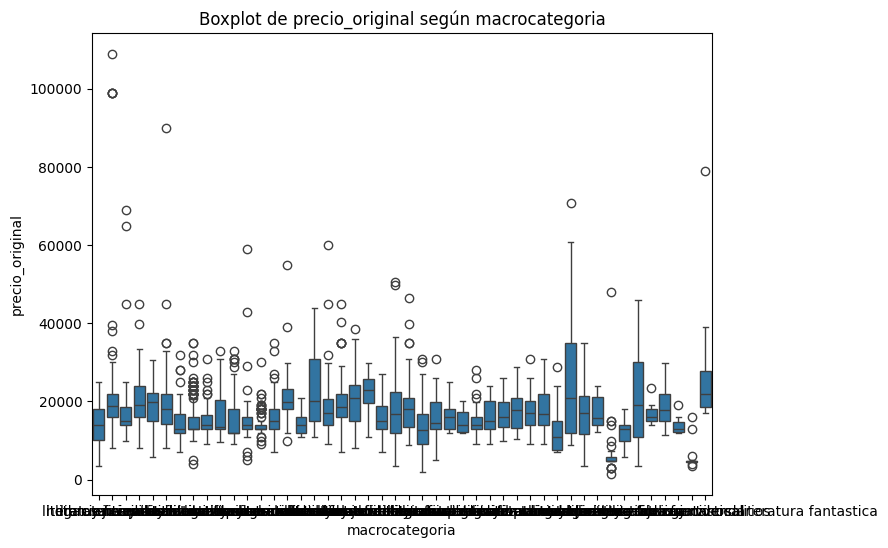

46

In [20]:
#Realizamos test anova y kruskal wallis para la variable macrocategoria
grupos = [g["precio_original"].values for _, g in df.groupby("macrocategoria")]
f_stat, p_anova = f_oneway(*grupos)
print("ANOVA -> F =", f_stat, "p-valor =", p_anova)
h_stat, p_kw = kruskal(*grupos)
print("Kruskal-Wallis -> H =", h_stat, "p-valor =", p_kw)
# Boxplot
plt.figure(figsize=(8,6))
sns.boxplot(x="macrocategoria", y="precio_original", data=df)
plt.title("Boxplot de precio_original según macrocategoria")
plt.show()
len(df["macrocategoria"].value_counts())

In [21]:
#Según lo observado en las gráficas y los test de comparación de medias respecto a las variables categóricas, se concluye que existen diferencias significativas.
#Por otra parte, tanto editorial como macrocategoría presentan una gran cantidad de grupos distintos, por lo que es dudosa su inclusión dentro del modelo.

## Etapa de modelado

In [22]:
#realizamos copia para ser utilizada en el siguiente modelo
df1=df.copy() #para el modelo de precio_oferta
df2=df.copy() #para el modelo de rango_descuento

### Modelo regresión lineal para precio_original

In [23]:
#Nos deshacemos de las variables que no serán consideradas para un modelo.
df = df.drop(columns=["titulo","categoria", "autor", "descripcion", "link", "precio_oferta","porcentaje_descuento","rango_descuento","largo","ancho","grosor","disponibles"])
#Separamos e identificamos variables numéricas y categóricas
variables_numericas = df.select_dtypes(include="number").columns.tolist()
variables_categoricas = df.select_dtypes(include=["object","category"]).columns.tolist()
df[variables_numericas].corr()

,precio_original,peso_kg,ano_edicion,paginas,volumen
precio_original,1.000000,0.740554,0.296585,0.580698,0.494245
peso_kg,0.740554,1.000000,0.078988,0.702370,0.606318
ano_edicion,0.296585,0.078988,1.000000,0.103725,0.134709
paginas,0.580698,0.702370,0.103725,1.000000,0.500389
volumen,0.494245,0.606318,0.134709,0.500389,1.000000


In [24]:
#Estandarizamos las variables numéricas
df = estandarizar(df)
#realizamos one-hot encoding en las variables categóricas
df = pd.get_dummies(df, columns=variables_categoricas, drop_first=True)
df = df.astype(float)

In [25]:
#Separamos la variable objetivo y los conjuntos de entrenamiento
X = df.drop("precio_original", axis=1)
y = df["precio_original"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Entrenamiento:
R²: 0.77947374203661
MSE: 0.22888754651965237
RMSE: 0.4784219335687405

Prueba:
R²: 0.7223420547683129
MSE: 0.235057091111185
RMSE: 0.4848268671507232


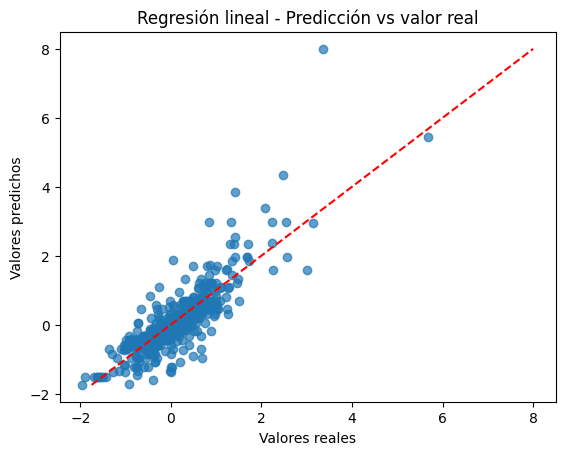

In [26]:
#Modelo con sklearn

#Creamos y ajustamos el modelo
modelo = LinearRegression()
modelo.fit(X_train, y_train)
joblib.dump(modelo, "../models/prediccion_precio_original_1.joblib")
#Realizamos las predicciones
y_pred_train = modelo.predict(X_train)
y_pred_test = modelo.predict(X_test)

# Métricas de error y bondad de ajuste tanto del entrenamiento como predicción.
print("Entrenamiento:")
print("R²:", r2_score(y_train, y_pred_train))
print("MSE:", mean_squared_error(y_train, y_pred_train))
print("RMSE:",  np.sqrt(mean_squared_error(y_train, y_pred_train)))
print("\nPrueba:")
print("R²:", r2_score(y_test, y_pred_test))
print("MSE:", mean_squared_error(y_test, y_pred_test))
print("RMSE:",  np.sqrt(mean_squared_error(y_test, y_pred_test)))
#Gráfica comparativa de predicción vs valor real
plt.scatter(y_pred_test, y_test, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("Valores reales")
plt.ylabel("Valores predichos")
plt.title("Regresión lineal - Predicción vs valor real")
plt.show()

In [27]:
#Modelo con statsmodel

#Agregamos la constante
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)
# Inserta la constante como primera columna
#X_test_const = X_test.copy()
#X_test_const.insert(0, "const", 1)

#Creamos y ajustamos el modelo
modelo = sm.OLS(y_train, X_train_const).fit()
joblib.dump(modelo, "../models/prediccion_precio_original_2.joblib")
# Resumen con p-valores y significancia
print(modelo.summary())
#Realizamos las predicciones
y_pred_test = modelo.predict(X_test_const)
# Métricas de error y bondad de ajuste de la predicción.
print("R² en test:", r2_score(y_test, y_pred_test))
print("MSE:", mean_squared_error(y_test, y_pred_test))
print("RMSE:",  np.sqrt(mean_squared_error(y_test, y_pred_test)))


                            OLS Regression Results                            
Dep. Variable:        precio_original   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     71.07
Date:                Mon, 25 Aug 2025   Prob (F-statistic):               0.00
Time:                        15:06:08   Log-Likelihood:                -1482.6
No. Observations:                2175   AIC:                             3173.
Df Residuals:                    2071   BIC:                             3765.
Df Model:                         103                                         
Covariance Type:            nonrobust                                         
                                                                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

In [28]:
#Una vez entregado el modelo. Terminamos con la predicción.
#Ahora se procederá con la predicción para la variable precio_oferta.

### Modelo regresión lineal para precio_oferta

In [29]:
#Nos deshacemos de las variables que no serán consideradas para un modelo.
df1 = df1.drop(columns=["titulo","categoria", "autor", "descripcion", "link","porcentaje_descuento","rango_descuento","largo","ancho","grosor","disponibles"])
#Separamos e identificamos variables numéricas y categóricas
variables_numericas = df1.select_dtypes(include="number").columns.tolist()
variables_categoricas = df1.select_dtypes(include=["object","category"]).columns.tolist()
df1[variables_numericas].corr()

,precio_original,precio_oferta,peso_kg,ano_edicion,paginas,volumen
precio_original,1.000000,0.859682,0.740554,0.296585,0.580698,0.494245
precio_oferta,0.859682,1.000000,0.665507,0.282899,0.600709,0.446384
peso_kg,0.740554,0.665507,1.000000,0.078988,0.702370,0.606318
ano_edicion,0.296585,0.282899,0.078988,1.000000,0.103725,0.134709
paginas,0.580698,0.600709,0.702370,0.103725,1.000000,0.500389
volumen,0.494245,0.446384,0.606318,0.134709,0.500389,1.000000


In [30]:
#Estandarizamos las variables numéricas
df1 = estandarizar(df1)
#realizamos one-hot encoding en las variables categóricas
df1 = pd.get_dummies(df1, columns=variables_categoricas, drop_first=True)
df1 = df1.astype(float)

In [31]:
#Separamos la variable objetivo y los conjuntos de entrenamiento
X = df1.drop("precio_oferta", axis=1)
y = df1["precio_oferta"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Entrenamiento:
R²: 0.8122998251162348
MSE: 0.19553901242511215
RMSE: 0.44219793353781306

Prueba:
R²: 0.6873130225020792
MSE: 0.2594908375515121
RMSE: 0.5094024318272461


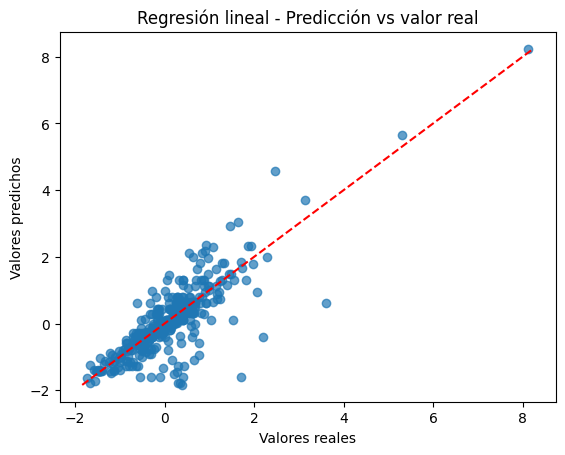

In [32]:
#Modelo con sklearn

#Creamos y ajustamos el modelo
modelo = LinearRegression()
modelo.fit(X_train, y_train)
joblib.dump(modelo, "../models/prediccion_precio_oferta_1.joblib")
#Realizamos las predicciones
y_pred_train = modelo.predict(X_train)
y_pred_test = modelo.predict(X_test)

# Métricas de error y bondad de ajuste tanto del entrenamiento como predicción.
print("Entrenamiento:")
print("R²:", r2_score(y_train, y_pred_train))
print("MSE:", mean_squared_error(y_train, y_pred_train))
print("RMSE:",  np.sqrt(mean_squared_error(y_train, y_pred_train)))
print("\nPrueba:")
print("R²:", r2_score(y_test, y_pred_test))
print("MSE:", mean_squared_error(y_test, y_pred_test))
print("RMSE:",  np.sqrt(mean_squared_error(y_test, y_pred_test)))
#Gráfica comparativa de predicción vs valor real
plt.scatter(y_pred_test, y_test, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("Valores reales")
plt.ylabel("Valores predichos")
plt.title("Regresión lineal - Predicción vs valor real")
plt.show()

In [33]:
#Modelo con statsmodel
#Agregamos la constante
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

#Creamos y ajustamos el modelo
modelo = sm.OLS(y_train, X_train_const).fit()
joblib.dump(modelo, "../models/prediccion_precio_oferta_2.joblib")
# Resumen con p-valores y significancia
print(modelo.summary())
#Realizamos las predicciones
y_pred_test = modelo.predict(X_test_const)
# Métricas de error y bondad de ajuste de la predicción.
print("R² en test:", r2_score(y_test, y_pred_test))
print("MSE:", mean_squared_error(y_test, y_pred_test))
print("RMSE:",  np.sqrt(mean_squared_error(y_test, y_pred_test)))

                            OLS Regression Results                            
Dep. Variable:          precio_oferta   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     86.14
Date:                Mon, 25 Aug 2025   Prob (F-statistic):               0.00
Time:                        15:06:09   Log-Likelihood:                -1311.4
No. Observations:                2175   AIC:                             2833.
Df Residuals:                    2070   BIC:                             3430.
Df Model:                         104                                         
Covariance Type:            nonrobust                                         
                                                                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

In [34]:
#Una vez entregado el modelo. Terminamos con la predicción.
#Ahora se procederá con la predicción para la variable rango_descuento.

### Modelo regresión multinomial ordinal para rango_descuento

In [35]:
#Nos deshacemos de las variables que no serán consideradas para un modelo.
y = df2["rango_descuento"] #apartamos la variable antes de la estandarización y el OHE para más simplicidad.
df2 = df2.drop(columns=["titulo","categoria", "autor", "descripcion", "link","porcentaje_descuento","precio_oferta","rango_descuento","largo","ancho","grosor", "disponibles"])
#Separamos e identificamos variables numéricas y categóricas
variables_numericas = df2.select_dtypes(include="number").columns.tolist()
variables_categoricas = df2.select_dtypes(include=["object","category"]).columns.tolist()
df2[variables_numericas].corr()

,precio_original,peso_kg,ano_edicion,paginas,volumen
precio_original,1.000000,0.740554,0.296585,0.580698,0.494245
peso_kg,0.740554,1.000000,0.078988,0.702370,0.606318
ano_edicion,0.296585,0.078988,1.000000,0.103725,0.134709
paginas,0.580698,0.702370,0.103725,1.000000,0.500389
volumen,0.494245,0.606318,0.134709,0.500389,1.000000


In [36]:
#Estandarizamos las variables numéricas
df2 = estandarizar(df2)
#realizamos one-hot encoding en las variables categóricas
df2 = pd.get_dummies(df2, columns=variables_categoricas, drop_first=True)
df2 = df2.astype(float)

In [37]:
#Separamos la variable objetivo y los conjuntos de entrenamiento
X = df2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
#Aplicamos SMOTE para resamplear los datos.
smote = SMOTE(random_state=42)
#Aplicamos SMOTE
X_train, y_train = smote.fit_resample(X_train, y_train)
#Revisamos el balance
print(y_train.value_counts())

rango_descuento
<0.2         1259
0.20-0.24    1259
0.25-0.29    1259
0.3 o más    1259
Name: count, dtype: int64


                             OrderedModel Results                             
Dep. Variable:        rango_descuento   Log-Likelihood:                -5751.0
Model:                   OrderedModel   AIC:                         1.172e+04
Method:            Maximum Likelihood   BIC:                         1.241e+04
Date:                Mon, 25 Aug 2025                                         
Time:                        15:12:36                                         
No. Observations:                5036                                         
Df Residuals:                    4929                                         
Df Model:                         104                                         
                                                                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------
precio_original

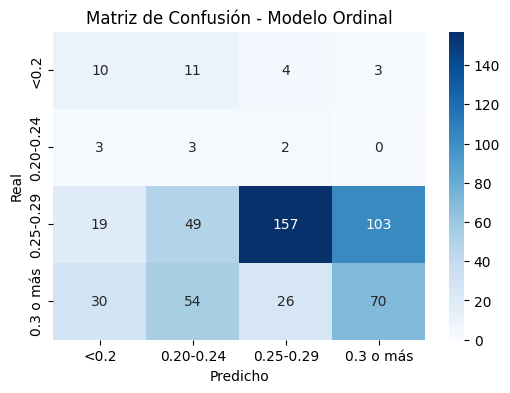

In [39]:
#Modelo con statsmodel
#Agregamos la constante
#No la utilizaremos porque no hace falta, pero se deja definido igualmente.
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

#Creamos y ajustamos el modelo
modelo = OrderedModel(
    y_train,
    X_train,
    distr='logit'  # 'logit' o 'probit'
)
res = modelo.fit(method='lbfgs',maxiter=3000, disp=True)
# Resumen con p-valores y significancia
print(res.summary())
joblib.dump(res, "../models/prediccion_descuento.joblib")

# Predicciones

# Probabilidades de cada categoría
probs = res.predict(X_test)
#Obtenemos el índice de la categoría con mayor probabilidad
y_pred_idx = np.argmax(probs.values, axis=1)
#Convertimos los índices a etiquetas respectivas
y_pred = pd.Categorical.from_codes(y_pred_idx, y.cat.categories)
#Comparamos con los valores reales para ver la efectividad de la predicción.
print("Accuracy test:", accuracy_score(y_test, y_pred))
#Matriz de confusión
cm = confusion_matrix(y_test, y_pred, labels=y_train.cat.categories)
#Convertimos a dataframe para mejor visualización y graficar la matriz de confusión.
cm_df = pd.DataFrame(cm, index=y_train.cat.categories, columns=y_train.cat.categories)
#Graficamos
plt.figure(figsize=(6,4))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Modelo Ordinal")
plt.show()

In [40]:
# Accuracy
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)
# Reporte completo: precision, recall, f1-score por categoría
print("\nClassification Report:\n", classification_report(y_test, y_pred))
# Cohen Kappa (mide concordancia ajustada por azar, útil en ordinal)
kappa = cohen_kappa_score(y_test, y_pred, weights="quadratic")  # "linear" o "quadratic"
print("Cohen's Kappa (ponderado):", kappa)
# Macro F1 (promedio de F1 por clase)
macro_f1 = f1_score(y_test, y_pred, average="macro")
print("Macro F1:", macro_f1)

Accuracy: 0.4411764705882353

Classification Report:
               precision    recall  f1-score   support

   0.20-0.24       0.03      0.38      0.05         8
   0.25-0.29       0.83      0.48      0.61       328
   0.3 o más       0.40      0.39      0.39       180
        <0.2       0.16      0.36      0.22        28

    accuracy                           0.44       544
   macro avg       0.35      0.40      0.32       544
weighted avg       0.64      0.44      0.51       544

Cohen's Kappa (ponderado): 0.05904998182090382
Macro F1: 0.3177076864750783


In [41]:
#La predicción está bien, debido a la utilización de SMOTE. Sin este, sucedía que la clase <0.2 no era identificada.

idea: crear un modelo para clasificar el rango de descuento (o precio de oferta) considerando los precios originales, ya que es un factor que puede influir a siempre tener ofertas impuestas a los libros sin necesidad de pensarlo mucho